In [89]:
from Utility import blockproc
import numpy as np
from PIL import Image
# from scipy import ndimage

import matplotlib.pyplot as plt
from scipy.fftpack import dct
from scipy.fftpack import idct

In [90]:
colaImage = Image.open("cola.jpg")
colaImageMat = np.array(colaImage)
colaImageMat.shape

(640, 640, 3)

In [91]:
blockproc(colaImageMat[:,:,0], [10,10], np.mean)

array([[180.01, 180.01, 180.01, ..., 173.71, 173.71, 173.71],
       [180.01, 180.01, 180.01, ..., 173.71, 173.71, 173.71],
       [180.01, 180.01, 180.01, ..., 173.71, 173.71, 173.71],
       ...,
       [209.42, 209.42, 209.42, ..., 212.92, 212.92, 212.92],
       [209.42, 209.42, 209.42, ..., 212.92, 212.92, 212.92],
       [209.42, 209.42, 209.42, ..., 212.92, 212.92, 212.92]])


# 1.1 Optimal Color Space

In [4]:
def colortrans(imgMat):
    """
    imgMat: rgb image as a 3D np array
    ------
    return
    ycbcr: ycbcr image as a 3D np array
    """
    shape = imgMat.shape
    ycbcr = np.zeros(shape)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            l = np.array([0,128,128])
            rgb = np.array([imgMat[i,j,0], imgMat[i,j,1], imgMat[i,j,2]])
            transMat = np.array([[.299,.587,.114],[-.168736,-.331264,.5],[.5,-.418688,-0.081312]])
            
            ycbcr[i,j,:] += l + np.matmul(transMat, rgb)
            
    return ycbcr

In [5]:
def invcolortrans(imgMat):
    """
    imgMat: ycbcr image as 3D np array
    --------
    return
    rgb: rgb image as 3D np array
    """
    shape = imgMat.shape
    rgb = np.zeros(shape)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            l = np.array([0,128,128])
            ycbcr = np.array([imgMat[i,j,0], imgMat[i,j,1], imgMat[i,j,2]])
            transMat = np.array([[.299,.587,.114],[-.168736,-.331264,.5],[.5,-.418688,-0.081312]])
            transMat = np.linalg.inv(transMat)
            
            diff = ycbcr - l
            rgb[i,j,:] += np.matmul(transMat, diff)
            
    return rgb

In [6]:
ycbcr = colortrans(colaImageMat)
rgb = invcolortrans(ycbcr)

In [7]:
np.sum(rgb - colaImageMat)

-6.755278984954752e-09

# 1.2 Downsample

In [8]:
def downsample(imgChannel, w):
    
    meanImg = blockproc(imgChannel, [w,w], np.mean)
    shape = imgChannel.shape
    downsampleImg = np.zeros((shape[0]//w, shape[1]//w))
    
    for i in range(0, shape[0]//w):
        for j in range(0,shape[1]//w):
            
            downsampleImg[i,j] = meanImg[i+ w//2, j+w//2]
            
    return downsampleImg

In [9]:
q1 = downsample(ycbcr[:,:,1],4)

In [10]:
print(downsample(ycbcr[:,:,1],4).shape)

(160, 160)


In [11]:
def upsample(downsampledImgChannel, w=4):
    
    shape = downsampledImgChannel.shape
    newShape = (shape[0]*w, shape[1]*w)
    upsampledImg = np.zeros(newShape)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            upsampledImg[i:i+w, j:j+w] = downsampledImgChannel[i,j]
            
    return upsampledImg

In [12]:
upsample(q1).shape

(640, 640)

# 1.3 Quantization

In [13]:
def quanmat(imgBlock):
    
    d = np.array(
                    [8 ,16, 19, 22, 26, 27, 29, 34,
                    16, 16, 22, 24, 27, 29, 34, 37,
                    19, 22, 26, 27, 29, 34, 34, 38,
                    22, 22, 26, 27, 29, 34, 37, 22,
                    22, 26, 27, 29, 32, 35, 40, 22,
                    26, 27, 29, 32, 35, 40, 48, 58,
                    26, 27, 29, 36, 38, 46, 56, 69,
                    27, 30, 35, 46, 46, 56, 69, 8 ]      )
    
    d = d.reshape(8,8)
    
    quantizedBlock = np.zeros((imgBlock.shape))
    for i in range(imgBlock.shape[0]):
        for j in range(imgBlock.shape[1]):
            
            quantizedBlock[i,j] = imgBlock[i,j]//d[i,j]
                         
    
    return quantizedBlock
            

In [14]:
blockproc(colaImageMat[:,:,0], [8,8], quanmat)

array([[21., 10.,  8., ...,  6.,  5.,  4.],
       [11., 11.,  8., ...,  5.,  4.,  4.],
       [ 8.,  8.,  7., ...,  4.,  5.,  4.],
       ...,
       [ 8.,  7.,  7., ...,  5.,  4.,  3.],
       [ 8.,  7.,  7., ...,  4.,  3.,  3.],
       [ 7.,  6.,  5., ...,  3.,  3., 26.]])

In [15]:
def invquanmat(imgBlock):
    
    d = np.array(
                    [8 ,16, 19, 22, 26, 27, 29, 34,
                    16, 16, 22, 24, 27, 29, 34, 37,
                    19, 22, 26, 27, 29, 34, 34, 38,
                    22, 22, 26, 27, 29, 34, 37, 22,
                    22, 26, 27, 29, 32, 35, 40, 22,
                    26, 27, 29, 32, 35, 40, 48, 58,
                    26, 27, 29, 36, 38, 46, 56, 69,
                    27, 30, 35, 46, 46, 56, 69, 8 ]      )
    
    d = d.reshape(8,8)
    
    invquantizedBlock = np.zeros((imgBlock.shape))
    for i in range(imgBlock.shape[0]):
        for j in range(imgBlock.shape[1]):
            
            invquantizedBlock[i,j] = imgBlock[i,j]*d[i,j]
                         
    
    return invquantizedBlock

In [25]:
d = np.array(
                    [8 ,16, 19, 22, 26, 27, 29, 34,
                    16, 16, 22, 24, 27, 29, 34, 37,
                    19, 22, 26, 27, 29, 34, 34, 38,
                    22, 22, 26, 27, 29, 34, 37, 22,
                    22, 26, 27, 29, 32, 35, 40, 22,
                    26, 27, 29, 32, 35, 40, 48, 58,
                    26, 27, 29, 36, 38, 46, 56, 69,
                    27, 30, 35, 46, 46, 56, 69, 8 ]      )
    
d = d.reshape(8,8)

# 1.4 DCT

In [139]:
y_dash = blockproc(colaImageMat[:,:,0], [8,8], dct)
cb_dash = blockproc(colaImageMat[:,:,1], [8,8], dct)
cr_dash = blockproc(colaImageMat[:,:,2], [8,8], dct)

In [140]:
y_dash = blockproc(y_dash, [8,8], quanmat)
cb_dash = blockproc(cb_dash, [8,8], quanmat)
cr_dash = blockproc(cr_dash, [8,8], quanmat)

In [141]:
newY = blockproc(y_dash, [8,8], invquanmat)
newCb = blockproc(cb_dash, [8,8], invquanmat)
newCr= blockproc(cr_dash, [8,8], invquanmat)

In [142]:
newY = blockproc(newY, [8,8], idct)
newCb = blockproc(cb_dash, [8,8], idct)
newCr= blockproc(cr_dash, [8,8], idct)

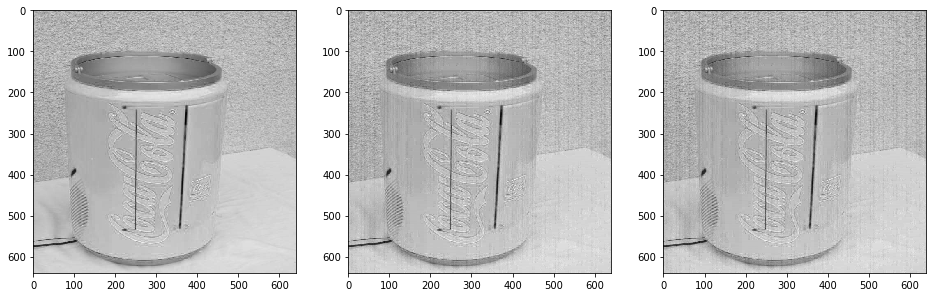

In [143]:
images = [colaImageMat[:,:,0], newY, newY - colaImageMat[:,:,0] ]

fig=plt.figure(figsize=(16, 16))

columns = 3
rows = 1
for i in range(1, 4):
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1], cmap = "gray")
plt.show()